In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/ubuntu/graphseq-inference/")
from graphseq_inference.models import *

In [2]:
import networkx as nx
import tsinfer
from torch_geometric.utils import from_networkx
import tskit
import os
import numpy as np
import tsdate

In [3]:
import torch
import numpy as np
import random
import os

def seed_everything(seed):
    """
    Seed everything to make all random processes reproducible.
    :param seed: An integer for the seed.
    :return: None
    """
    random.seed(seed)            # Python random module
    np.random.seed(seed)         # Numpy
    torch.manual_seed(seed)      # PyTorch
    torch.cuda.manual_seed(seed) # PyTorch CUDA (for GPU computation)
    torch.cuda.manual_seed_all(seed) # PyTorch CUDA (for all GPUs)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)  # Environment variable

# Example usage
seed = 42
seed_everything(seed)

In [4]:
label_lookup = {
    "kingman_selection_none" : 0,
    "kingman_selection_weak" : 1,
    "kingman_selection_medium" : 2,
    "kingman_selection_strong" : 3,
    
    "beta_selection_a1.99-1.75" : 4,
    "beta_selection_a1.75-1.50" : 5,
    "beta_selection_a1.50-1.25" : 6,
    "beta_selection_a1.25-1.01" : 7,    
}


def get_y_label_from_y_dict(y_dict):
    reproduction_model, parameter = y_dict["model"]

    if reproduction_model == "beta":
        if parameter < 1.25: return torch.Tensor([7]).long()
        if parameter < 1.5: return torch.Tensor([6]).long()
        if parameter < 1.75: return torch.Tensor([5]).long()
        if parameter < 2: return torch.Tensor([4]).long()
    else:
        label = y_dict["model"][0] + "_selection_" + y_dict["selection_type"]
        y = torch.Tensor([label_lookup[label]]).long()
        return y

def convert_for_classification(file: tskit.trees.TreeSequence):
    data_objects, y_dict = torch.load(file)    
    y = get_y_label_from_y_dict(y_dict)
    for data in data_objects: data.y = y
    return data_objects

In [5]:
class ClassificationModel(nn.Module):
    
    def __init__(self, DemographyNet, num_classes, time_window=60):
        super().__init__()
        self.l1 = nn.Linear(time_window, time_window//2)
        self.l2 = nn.Linear(time_window//2, num_classes)
        self.DemographyNet = DemographyNet
    
    def forward(self, batch):
        x = self.DemographyNet(batch)
        return self.l2(F.relu(self.l1(x)))

In [6]:
def calculate_accuracy(predictions, targets):
    predictions_tensor = torch.tensor(predictions)
    targets_tensor = torch.tensor(targets)
    
    correct = (predictions_tensor == targets_tensor).sum().item()
    total = targets_tensor.size(0)
    accuracy = correct / total
    return accuracy

In [31]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60)#.to(device)
model = ClassificationModel(demography_net, num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()

In [79]:
directory = "./classification-dataset/"
files = os.listdir(directory)
files = [directory +  file for file in files]
print(len(files))
# restrict to 5000 since there are only 4000 inferred sequences
files = files[:5000]
print(len(files))

40000
5000


In [80]:
#directory = "./classification-dataset-inf/"
#files = os.listdir(directory)
#files = [directory +  file for file in files]
#len(files)

train_files = files[:int(len(files)*0.8)]
test_files = files[int(len(files)*0.8):]

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [35]:
length = 60
accum_iter = 64

loss_all = []
y_hats = []
y_trues = []
accs = []
loss_train_test = []

for epoch in range(0, 20):
    np.random.shuffle(train_files)
    y_trues = []
    y_hats = []
    loss_all = []
    for i in tqdm(range(len(train_files))):
        data_objects = convert_for_classification(train_files[i])
        dl = DataLoader(data_objects, batch_size=len(data_objects))
        for batch in dl:
            batch = batch.to(device)
            y_hat = model(batch)
            y_hat = y_hat.sum(0) 
            y_true = batch.y[0]
            loss = criterion(y_hat, y_true) 
            loss = loss / accum_iter 
            loss.backward()
            
            loss_all.append(loss.item())
            y_trues.append(y_true.item())
            y_hats.append(torch.argmax(y_hat).item())
            
        if i != 0 and i % accum_iter == 0:
            acc = calculate_accuracy(y_hats, y_trues)
            accs.append(acc)
            
            fmt_loss = f'Epoch: {epoch:03d}, Train Loss: {np.mean(loss_all)*accum_iter:.4f}, Acc: {acc:.4f}'
            print(fmt_loss)
            os.system(f'echo {epoch:03d}, {np.mean(loss_all)*accum_iter:.4f}, {np.mean(accs):.4f} >> ./logs/log_train_exact_trees_during_training.txt')
            optimizer.step()
            optimizer.zero_grad()
            loss_train_test.append(np.mean(loss_all)*accum_iter)
            y_trues = []
            y_hats = []
            loss_all = []
    
    os.system(f'echo {epoch:03d}, {np.mean(loss_train_test):.4f}, {np.mean(accs):.4f} >> ./logs/log_train_exact_trees.txt')
    torch.save(model.state_dict(), "./chkps/exact_model_chkp" + str(epoch) + "_" + str(i) + ".pth")
    loss_train_test = []
    loss_all = []
    y_hats = []
    y_trues = []
    accs = []
    
    with torch.no_grad():
        for i in tqdm(range(len(test_files))):
            data_objects = convert_for_classification(test_files[i])
            dl = DataLoader(data_objects, batch_size=len(data_objects))
            for batch in dl:
                batch = batch.to(device)
                y_hat = model(batch)
                y_hat = y_hat.sum(0) 
                y_true = batch.y[0]
                
                loss = criterion(y_hat, y_true) 
                loss_all.append(loss.item())
                
                y_trues.append(y_true.item())
                y_hats.append(torch.argmax(y_hat).item())
                    
        acc = calculate_accuracy(y_hats, y_trues)
        accs.append(acc)
        fmt_loss = f'Epoch: {epoch:03d}, Test loss: {np.mean(loss_all):.4f}, {np.mean(accs):.4f}'
        print(fmt_loss)
        os.system(f'echo {epoch:03d}, {np.mean(loss_all):.4f}, {np.mean(accs):.4f} >> ./logs/log_test_exact_trees.txt')
        loss_all = []
        accs = []

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 000, Train Loss: 77.6499, Acc: 0.1719
Epoch: 000, Train Loss: 95.2477, Acc: 0.0938
Epoch: 000, Train Loss: 90.2537, Acc: 0.0781
Epoch: 000, Train Loss: 73.8854, Acc: 0.1406
Epoch: 000, Train Loss: 91.0332, Acc: 0.1094
Epoch: 000, Train Loss: 80.1042, Acc: 0.0938
Epoch: 000, Train Loss: 81.8994, Acc: 0.0938
Epoch: 000, Train Loss: 78.8727, Acc: 0.1094
Epoch: 000, Train Loss: 72.8560, Acc: 0.1250
Epoch: 000, Train Loss: 84.3045, Acc: 0.1094
Epoch: 000, Train Loss: 71.7272, Acc: 0.1250
Epoch: 000, Train Loss: 75.9117, Acc: 0.1875
Epoch: 000, Train Loss: 79.7787, Acc: 0.1250
Epoch: 000, Train Loss: 70.5675, Acc: 0.1875
Epoch: 000, Train Loss: 74.4881, Acc: 0.1406
Epoch: 000, Train Loss: 68.7277, Acc: 0.1562
Epoch: 000, Train Loss: 69.5913, Acc: 0.1562
Epoch: 000, Train Loss: 74.1003, Acc: 0.0938
Epoch: 000, Train Loss: 64.9445, Acc: 0.2031
Epoch: 000, Train Loss: 67.6809, Acc: 0.0938
Epoch: 000, Train Loss: 64.7562, Acc: 0.1094
Epoch: 000, Train Loss: 65.8996, Acc: 0.1250
Epoch: 000

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Test loss: 41.6188, 0.1680


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 43.3217, Acc: 0.1385
Epoch: 001, Train Loss: 44.2892, Acc: 0.1719
Epoch: 001, Train Loss: 39.8495, Acc: 0.1562
Epoch: 001, Train Loss: 44.9505, Acc: 0.0469
Epoch: 001, Train Loss: 35.8487, Acc: 0.1875
Epoch: 001, Train Loss: 35.5068, Acc: 0.1562
Epoch: 001, Train Loss: 43.8947, Acc: 0.1719
Epoch: 001, Train Loss: 41.3716, Acc: 0.1719
Epoch: 001, Train Loss: 39.7324, Acc: 0.0469
Epoch: 001, Train Loss: 32.8521, Acc: 0.2344
Epoch: 001, Train Loss: 46.7090, Acc: 0.1250
Epoch: 001, Train Loss: 35.2630, Acc: 0.2812
Epoch: 001, Train Loss: 45.1308, Acc: 0.2188
Epoch: 001, Train Loss: 34.8117, Acc: 0.1875
Epoch: 001, Train Loss: 40.6285, Acc: 0.1719
Epoch: 001, Train Loss: 30.4882, Acc: 0.2500
Epoch: 001, Train Loss: 40.6523, Acc: 0.1562
Epoch: 001, Train Loss: 25.3609, Acc: 0.2969
Epoch: 001, Train Loss: 31.8302, Acc: 0.2500
Epoch: 001, Train Loss: 32.3938, Acc: 0.1562
Epoch: 001, Train Loss: 37.4692, Acc: 0.1406
Epoch: 001, Train Loss: 39.2515, Acc: 0.1875
Epoch: 001

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 001, Test loss: 16.6288, 0.1400


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 002, Train Loss: 10.5839, Acc: 0.2615
Epoch: 002, Train Loss: 14.7048, Acc: 0.1406
Epoch: 002, Train Loss: 12.6975, Acc: 0.1406
Epoch: 002, Train Loss: 15.8392, Acc: 0.1562
Epoch: 002, Train Loss: 15.7128, Acc: 0.2500
Epoch: 002, Train Loss: 15.9632, Acc: 0.2500
Epoch: 002, Train Loss: 14.2903, Acc: 0.2344
Epoch: 002, Train Loss: 15.0600, Acc: 0.2188
Epoch: 002, Train Loss: 11.9626, Acc: 0.2031
Epoch: 002, Train Loss: 15.3623, Acc: 0.1562
Epoch: 002, Train Loss: 14.6944, Acc: 0.1719
Epoch: 002, Train Loss: 14.6537, Acc: 0.2188
Epoch: 002, Train Loss: 15.4240, Acc: 0.1875
Epoch: 002, Train Loss: 11.1384, Acc: 0.0781
Epoch: 002, Train Loss: 13.3067, Acc: 0.1719
Epoch: 002, Train Loss: 9.1149, Acc: 0.1094
Epoch: 002, Train Loss: 12.6897, Acc: 0.2188
Epoch: 002, Train Loss: 17.6262, Acc: 0.1875
Epoch: 002, Train Loss: 11.3072, Acc: 0.1562
Epoch: 002, Train Loss: 7.7281, Acc: 0.1094
Epoch: 002, Train Loss: 7.7236, Acc: 0.2344
Epoch: 002, Train Loss: 13.1906, Acc: 0.1406
Epoch: 002, T

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 002, Test loss: 9.1336, 0.1730


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 003, Train Loss: 7.6817, Acc: 0.2615
Epoch: 003, Train Loss: 3.8748, Acc: 0.4062
Epoch: 003, Train Loss: 6.3962, Acc: 0.2812
Epoch: 003, Train Loss: 8.8013, Acc: 0.2031
Epoch: 003, Train Loss: 9.0981, Acc: 0.2188
Epoch: 003, Train Loss: 5.6648, Acc: 0.2500
Epoch: 003, Train Loss: 5.4925, Acc: 0.2500
Epoch: 003, Train Loss: 6.7818, Acc: 0.2031
Epoch: 003, Train Loss: 7.7525, Acc: 0.1875
Epoch: 003, Train Loss: 7.4034, Acc: 0.2969
Epoch: 003, Train Loss: 9.4506, Acc: 0.2500
Epoch: 003, Train Loss: 6.7400, Acc: 0.2969
Epoch: 003, Train Loss: 9.6850, Acc: 0.1875
Epoch: 003, Train Loss: 5.4596, Acc: 0.2031
Epoch: 003, Train Loss: 7.0414, Acc: 0.3281
Epoch: 003, Train Loss: 8.1904, Acc: 0.2969
Epoch: 003, Train Loss: 9.1029, Acc: 0.2812
Epoch: 003, Train Loss: 8.7757, Acc: 0.3125
Epoch: 003, Train Loss: 9.2483, Acc: 0.2188
Epoch: 003, Train Loss: 4.8726, Acc: 0.2969
Epoch: 003, Train Loss: 6.6903, Acc: 0.3438
Epoch: 003, Train Loss: 3.6662, Acc: 0.3438
Epoch: 003, Train Loss: 8.1448, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 003, Test loss: 4.8746, 0.2470


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 004, Train Loss: 4.3236, Acc: 0.3692
Epoch: 004, Train Loss: 2.8961, Acc: 0.4531
Epoch: 004, Train Loss: 3.7794, Acc: 0.3125
Epoch: 004, Train Loss: 3.6548, Acc: 0.3906
Epoch: 004, Train Loss: 3.3361, Acc: 0.4375
Epoch: 004, Train Loss: 3.9521, Acc: 0.3281
Epoch: 004, Train Loss: 3.6607, Acc: 0.3906
Epoch: 004, Train Loss: 2.9790, Acc: 0.3594
Epoch: 004, Train Loss: 2.4166, Acc: 0.3750
Epoch: 004, Train Loss: 2.7023, Acc: 0.2969
Epoch: 004, Train Loss: 3.0605, Acc: 0.3438
Epoch: 004, Train Loss: 3.3211, Acc: 0.3438
Epoch: 004, Train Loss: 2.8315, Acc: 0.2812
Epoch: 004, Train Loss: 2.1405, Acc: 0.4375
Epoch: 004, Train Loss: 1.9852, Acc: 0.4219
Epoch: 004, Train Loss: 3.1061, Acc: 0.3594
Epoch: 004, Train Loss: 2.6622, Acc: 0.3125
Epoch: 004, Train Loss: 3.0239, Acc: 0.3125
Epoch: 004, Train Loss: 2.9080, Acc: 0.3281
Epoch: 004, Train Loss: 3.0142, Acc: 0.3281
Epoch: 004, Train Loss: 2.8191, Acc: 0.4688
Epoch: 004, Train Loss: 2.4470, Acc: 0.2656
Epoch: 004, Train Loss: 2.3959, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 004, Test loss: 2.4958, 0.3770


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 005, Train Loss: 1.3516, Acc: 0.5692
Epoch: 005, Train Loss: 1.3586, Acc: 0.5938
Epoch: 005, Train Loss: 1.7260, Acc: 0.5000
Epoch: 005, Train Loss: 1.4716, Acc: 0.5781
Epoch: 005, Train Loss: 1.7921, Acc: 0.5469
Epoch: 005, Train Loss: 1.4684, Acc: 0.4688
Epoch: 005, Train Loss: 1.4942, Acc: 0.5000
Epoch: 005, Train Loss: 1.2916, Acc: 0.5781
Epoch: 005, Train Loss: 1.5391, Acc: 0.4844
Epoch: 005, Train Loss: 1.0995, Acc: 0.6250
Epoch: 005, Train Loss: 1.6229, Acc: 0.5156
Epoch: 005, Train Loss: 1.7162, Acc: 0.4531
Epoch: 005, Train Loss: 1.3813, Acc: 0.5000
Epoch: 005, Train Loss: 1.5002, Acc: 0.5156
Epoch: 005, Train Loss: 1.5064, Acc: 0.4844
Epoch: 005, Train Loss: 1.4264, Acc: 0.5156
Epoch: 005, Train Loss: 1.5175, Acc: 0.4531
Epoch: 005, Train Loss: 1.1966, Acc: 0.6094
Epoch: 005, Train Loss: 1.3545, Acc: 0.5469
Epoch: 005, Train Loss: 1.3422, Acc: 0.5938
Epoch: 005, Train Loss: 1.3821, Acc: 0.5469
Epoch: 005, Train Loss: 1.4186, Acc: 0.4844
Epoch: 005, Train Loss: 1.6524, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 005, Test loss: 2.2282, 0.4380


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 006, Train Loss: 1.1962, Acc: 0.5538
Epoch: 006, Train Loss: 1.2386, Acc: 0.6719
Epoch: 006, Train Loss: 1.1467, Acc: 0.5625
Epoch: 006, Train Loss: 1.2610, Acc: 0.6250
Epoch: 006, Train Loss: 1.0037, Acc: 0.6875
Epoch: 006, Train Loss: 1.0687, Acc: 0.6250
Epoch: 006, Train Loss: 0.7921, Acc: 0.7344
Epoch: 006, Train Loss: 1.5404, Acc: 0.5312
Epoch: 006, Train Loss: 1.2097, Acc: 0.5938
Epoch: 006, Train Loss: 0.9265, Acc: 0.6406
Epoch: 006, Train Loss: 1.2583, Acc: 0.6406
Epoch: 006, Train Loss: 1.1140, Acc: 0.6406
Epoch: 006, Train Loss: 0.9670, Acc: 0.6719
Epoch: 006, Train Loss: 1.1677, Acc: 0.7344
Epoch: 006, Train Loss: 1.0132, Acc: 0.6875
Epoch: 006, Train Loss: 1.2158, Acc: 0.6094
Epoch: 006, Train Loss: 0.9189, Acc: 0.7031
Epoch: 006, Train Loss: 1.1367, Acc: 0.6094
Epoch: 006, Train Loss: 1.2011, Acc: 0.6094
Epoch: 006, Train Loss: 0.9498, Acc: 0.6250
Epoch: 006, Train Loss: 1.2844, Acc: 0.5938
Epoch: 006, Train Loss: 1.0070, Acc: 0.7031
Epoch: 006, Train Loss: 1.2037, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 006, Test loss: 2.1697, 0.4450


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 007, Train Loss: 0.9182, Acc: 0.6923
Epoch: 007, Train Loss: 1.0424, Acc: 0.6719
Epoch: 007, Train Loss: 0.9615, Acc: 0.5938
Epoch: 007, Train Loss: 0.8091, Acc: 0.7500
Epoch: 007, Train Loss: 0.9419, Acc: 0.7344
Epoch: 007, Train Loss: 1.0066, Acc: 0.6250
Epoch: 007, Train Loss: 0.7555, Acc: 0.7031
Epoch: 007, Train Loss: 1.4183, Acc: 0.6406
Epoch: 007, Train Loss: 1.0061, Acc: 0.6875
Epoch: 007, Train Loss: 1.1474, Acc: 0.6250
Epoch: 007, Train Loss: 1.1113, Acc: 0.6406
Epoch: 007, Train Loss: 0.8551, Acc: 0.6406
Epoch: 007, Train Loss: 1.1196, Acc: 0.7031
Epoch: 007, Train Loss: 1.1515, Acc: 0.5938
Epoch: 007, Train Loss: 1.0601, Acc: 0.5781
Epoch: 007, Train Loss: 1.0805, Acc: 0.5781
Epoch: 007, Train Loss: 0.8504, Acc: 0.6875
Epoch: 007, Train Loss: 1.0864, Acc: 0.6250
Epoch: 007, Train Loss: 0.7652, Acc: 0.7656
Epoch: 007, Train Loss: 1.3291, Acc: 0.6562
Epoch: 007, Train Loss: 0.9638, Acc: 0.6719
Epoch: 007, Train Loss: 0.8631, Acc: 0.6875
Epoch: 007, Train Loss: 0.6943, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 007, Test loss: 1.9950, 0.4830


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 008, Train Loss: 0.8070, Acc: 0.6769
Epoch: 008, Train Loss: 0.8025, Acc: 0.6875
Epoch: 008, Train Loss: 0.5735, Acc: 0.8281
Epoch: 008, Train Loss: 0.9712, Acc: 0.5938
Epoch: 008, Train Loss: 0.8184, Acc: 0.6250
Epoch: 008, Train Loss: 0.7858, Acc: 0.7500
Epoch: 008, Train Loss: 1.1381, Acc: 0.5625
Epoch: 008, Train Loss: 0.7133, Acc: 0.7344
Epoch: 008, Train Loss: 0.6353, Acc: 0.8125
Epoch: 008, Train Loss: 0.9087, Acc: 0.6562
Epoch: 008, Train Loss: 0.7385, Acc: 0.7188
Epoch: 008, Train Loss: 0.9847, Acc: 0.5312
Epoch: 008, Train Loss: 0.8546, Acc: 0.6875
Epoch: 008, Train Loss: 0.7513, Acc: 0.6875
Epoch: 008, Train Loss: 0.9134, Acc: 0.7344
Epoch: 008, Train Loss: 0.8665, Acc: 0.7500
Epoch: 008, Train Loss: 0.9795, Acc: 0.6406
Epoch: 008, Train Loss: 0.8131, Acc: 0.7031
Epoch: 008, Train Loss: 0.9392, Acc: 0.6875
Epoch: 008, Train Loss: 0.7734, Acc: 0.7969
Epoch: 008, Train Loss: 0.8367, Acc: 0.6250
Epoch: 008, Train Loss: 0.6338, Acc: 0.7812
Epoch: 008, Train Loss: 0.6053, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 008, Test loss: 1.9166, 0.4980


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 009, Train Loss: 0.8997, Acc: 0.7231
Epoch: 009, Train Loss: 0.7068, Acc: 0.7969
Epoch: 009, Train Loss: 0.9607, Acc: 0.6250
Epoch: 009, Train Loss: 0.7634, Acc: 0.7656
Epoch: 009, Train Loss: 0.8473, Acc: 0.7500
Epoch: 009, Train Loss: 0.7002, Acc: 0.7656
Epoch: 009, Train Loss: 0.6101, Acc: 0.7656
Epoch: 009, Train Loss: 0.5193, Acc: 0.8281
Epoch: 009, Train Loss: 0.6515, Acc: 0.6875
Epoch: 009, Train Loss: 0.7180, Acc: 0.7656
Epoch: 009, Train Loss: 0.7461, Acc: 0.7500
Epoch: 009, Train Loss: 0.7562, Acc: 0.7188
Epoch: 009, Train Loss: 0.7159, Acc: 0.7188
Epoch: 009, Train Loss: 0.6004, Acc: 0.7969
Epoch: 009, Train Loss: 0.6440, Acc: 0.7500
Epoch: 009, Train Loss: 0.7820, Acc: 0.7188
Epoch: 009, Train Loss: 0.5471, Acc: 0.7812
Epoch: 009, Train Loss: 0.5014, Acc: 0.8594
Epoch: 009, Train Loss: 0.8790, Acc: 0.7188
Epoch: 009, Train Loss: 1.0419, Acc: 0.7188
Epoch: 009, Train Loss: 0.7505, Acc: 0.7031
Epoch: 009, Train Loss: 0.5638, Acc: 0.8281
Epoch: 009, Train Loss: 0.9325, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 009, Test loss: 1.9417, 0.5010


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 010, Train Loss: 0.7547, Acc: 0.7077
Epoch: 010, Train Loss: 0.7356, Acc: 0.8125
Epoch: 010, Train Loss: 0.4981, Acc: 0.7344
Epoch: 010, Train Loss: 0.6218, Acc: 0.7812
Epoch: 010, Train Loss: 0.5952, Acc: 0.8438
Epoch: 010, Train Loss: 0.8267, Acc: 0.7188
Epoch: 010, Train Loss: 0.6377, Acc: 0.7656
Epoch: 010, Train Loss: 0.7362, Acc: 0.7656
Epoch: 010, Train Loss: 0.5554, Acc: 0.7969
Epoch: 010, Train Loss: 0.5937, Acc: 0.7969
Epoch: 010, Train Loss: 0.5927, Acc: 0.8438
Epoch: 010, Train Loss: 0.8052, Acc: 0.7344
Epoch: 010, Train Loss: 0.6435, Acc: 0.7812
Epoch: 010, Train Loss: 0.5526, Acc: 0.7344
Epoch: 010, Train Loss: 0.5997, Acc: 0.7656
Epoch: 010, Train Loss: 0.7394, Acc: 0.7031
Epoch: 010, Train Loss: 0.8773, Acc: 0.6719
Epoch: 010, Train Loss: 0.5959, Acc: 0.7812
Epoch: 010, Train Loss: 0.5392, Acc: 0.8594
Epoch: 010, Train Loss: 0.5742, Acc: 0.8594
Epoch: 010, Train Loss: 0.6543, Acc: 0.7812
Epoch: 010, Train Loss: 0.5854, Acc: 0.8125
Epoch: 010, Train Loss: 0.7051, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 010, Test loss: 1.8677, 0.5170


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 011, Train Loss: 0.6873, Acc: 0.7692
Epoch: 011, Train Loss: 0.4801, Acc: 0.8906
Epoch: 011, Train Loss: 0.4725, Acc: 0.7969
Epoch: 011, Train Loss: 0.7060, Acc: 0.7969
Epoch: 011, Train Loss: 0.5691, Acc: 0.7812
Epoch: 011, Train Loss: 0.5316, Acc: 0.7969
Epoch: 011, Train Loss: 0.4822, Acc: 0.7812
Epoch: 011, Train Loss: 0.6211, Acc: 0.7656
Epoch: 011, Train Loss: 0.5980, Acc: 0.7188
Epoch: 011, Train Loss: 0.5710, Acc: 0.7812
Epoch: 011, Train Loss: 0.5124, Acc: 0.8594
Epoch: 011, Train Loss: 0.4699, Acc: 0.8594
Epoch: 011, Train Loss: 0.5815, Acc: 0.8281
Epoch: 011, Train Loss: 0.6441, Acc: 0.7812
Epoch: 011, Train Loss: 0.6226, Acc: 0.7656
Epoch: 011, Train Loss: 0.6569, Acc: 0.6406
Epoch: 011, Train Loss: 0.6466, Acc: 0.7656
Epoch: 011, Train Loss: 0.4484, Acc: 0.8906
Epoch: 011, Train Loss: 0.7425, Acc: 0.7188
Epoch: 011, Train Loss: 0.5671, Acc: 0.7812
Epoch: 011, Train Loss: 0.4699, Acc: 0.8438
Epoch: 011, Train Loss: 0.5837, Acc: 0.8438
Epoch: 011, Train Loss: 0.5574, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 011, Test loss: 1.8497, 0.5170


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 012, Train Loss: 0.5673, Acc: 0.8462
Epoch: 012, Train Loss: 0.5348, Acc: 0.7812
Epoch: 012, Train Loss: 0.3569, Acc: 0.9375
Epoch: 012, Train Loss: 0.6211, Acc: 0.7969
Epoch: 012, Train Loss: 0.5346, Acc: 0.7969
Epoch: 012, Train Loss: 0.4081, Acc: 0.8750
Epoch: 012, Train Loss: 0.4727, Acc: 0.8594
Epoch: 012, Train Loss: 0.4983, Acc: 0.7969
Epoch: 012, Train Loss: 0.5823, Acc: 0.7969
Epoch: 012, Train Loss: 0.4572, Acc: 0.8906
Epoch: 012, Train Loss: 0.4530, Acc: 0.8906
Epoch: 012, Train Loss: 0.5733, Acc: 0.7812
Epoch: 012, Train Loss: 0.3897, Acc: 0.9062
Epoch: 012, Train Loss: 0.5007, Acc: 0.8438
Epoch: 012, Train Loss: 0.4597, Acc: 0.8594
Epoch: 012, Train Loss: 0.4230, Acc: 0.9062
Epoch: 012, Train Loss: 0.4529, Acc: 0.8125
Epoch: 012, Train Loss: 0.5162, Acc: 0.8281
Epoch: 012, Train Loss: 0.6927, Acc: 0.7500
Epoch: 012, Train Loss: 0.5314, Acc: 0.7969
Epoch: 012, Train Loss: 0.4398, Acc: 0.8438
Epoch: 012, Train Loss: 0.5881, Acc: 0.8125
Epoch: 012, Train Loss: 0.4786, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 012, Test loss: 1.7716, 0.5290


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 013, Train Loss: 0.5126, Acc: 0.8308
Epoch: 013, Train Loss: 0.6381, Acc: 0.7812
Epoch: 013, Train Loss: 0.5052, Acc: 0.8125
Epoch: 013, Train Loss: 0.3453, Acc: 0.9219
Epoch: 013, Train Loss: 0.3979, Acc: 0.8594
Epoch: 013, Train Loss: 0.4461, Acc: 0.8906
Epoch: 013, Train Loss: 0.4254, Acc: 0.8906
Epoch: 013, Train Loss: 0.4517, Acc: 0.9062
Epoch: 013, Train Loss: 0.4558, Acc: 0.8594
Epoch: 013, Train Loss: 0.4126, Acc: 0.8281
Epoch: 013, Train Loss: 0.4638, Acc: 0.8594
Epoch: 013, Train Loss: 0.4627, Acc: 0.8125
Epoch: 013, Train Loss: 0.3961, Acc: 0.9062
Epoch: 013, Train Loss: 0.4329, Acc: 0.8906
Epoch: 013, Train Loss: 0.3821, Acc: 0.9219
Epoch: 013, Train Loss: 0.5796, Acc: 0.8594
Epoch: 013, Train Loss: 0.4356, Acc: 0.9062
Epoch: 013, Train Loss: 0.3945, Acc: 0.8906
Epoch: 013, Train Loss: 0.5099, Acc: 0.7812
Epoch: 013, Train Loss: 0.4065, Acc: 0.8906
Epoch: 013, Train Loss: 0.4824, Acc: 0.8438
Epoch: 013, Train Loss: 0.3959, Acc: 0.8906
Epoch: 013, Train Loss: 0.4606, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 013, Test loss: 1.7850, 0.5340


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 014, Train Loss: 0.5209, Acc: 0.8615
Epoch: 014, Train Loss: 0.4299, Acc: 0.9062
Epoch: 014, Train Loss: 0.3603, Acc: 0.9219
Epoch: 014, Train Loss: 0.3303, Acc: 0.9375
Epoch: 014, Train Loss: 0.4561, Acc: 0.8438
Epoch: 014, Train Loss: 0.4702, Acc: 0.8438
Epoch: 014, Train Loss: 0.2910, Acc: 0.9688
Epoch: 014, Train Loss: 0.4630, Acc: 0.8125
Epoch: 014, Train Loss: 0.4730, Acc: 0.8438
Epoch: 014, Train Loss: 0.3814, Acc: 0.9219
Epoch: 014, Train Loss: 0.4272, Acc: 0.8750
Epoch: 014, Train Loss: 0.4463, Acc: 0.8594
Epoch: 014, Train Loss: 0.4177, Acc: 0.8281
Epoch: 014, Train Loss: 0.3461, Acc: 0.9219
Epoch: 014, Train Loss: 0.4654, Acc: 0.8438
Epoch: 014, Train Loss: 0.3403, Acc: 0.9531
Epoch: 014, Train Loss: 0.3126, Acc: 0.9375
Epoch: 014, Train Loss: 0.3496, Acc: 0.9062
Epoch: 014, Train Loss: 0.4657, Acc: 0.8281
Epoch: 014, Train Loss: 0.3804, Acc: 0.8594
Epoch: 014, Train Loss: 0.4360, Acc: 0.8750
Epoch: 014, Train Loss: 0.4929, Acc: 0.7969
Epoch: 014, Train Loss: 0.4101, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 014, Test loss: 1.7794, 0.5520


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 015, Train Loss: 0.2886, Acc: 0.9385
Epoch: 015, Train Loss: 0.3587, Acc: 0.8906
Epoch: 015, Train Loss: 0.3904, Acc: 0.9062
Epoch: 015, Train Loss: 0.3998, Acc: 0.8750
Epoch: 015, Train Loss: 0.3567, Acc: 0.9219
Epoch: 015, Train Loss: 0.3956, Acc: 0.8594
Epoch: 015, Train Loss: 0.2932, Acc: 0.9375
Epoch: 015, Train Loss: 0.3543, Acc: 0.8281
Epoch: 015, Train Loss: 0.3837, Acc: 0.8906
Epoch: 015, Train Loss: 0.3625, Acc: 0.8906
Epoch: 015, Train Loss: 0.3405, Acc: 0.8750
Epoch: 015, Train Loss: 0.3911, Acc: 0.8750
Epoch: 015, Train Loss: 0.4163, Acc: 0.8281
Epoch: 015, Train Loss: 0.4136, Acc: 0.9219
Epoch: 015, Train Loss: 0.3692, Acc: 0.8438
Epoch: 015, Train Loss: 0.3486, Acc: 0.9062
Epoch: 015, Train Loss: 0.3749, Acc: 0.9062
Epoch: 015, Train Loss: 0.3913, Acc: 0.9219
Epoch: 015, Train Loss: 0.4893, Acc: 0.7969
Epoch: 015, Train Loss: 0.3283, Acc: 0.8750
Epoch: 015, Train Loss: 0.4098, Acc: 0.8750
Epoch: 015, Train Loss: 0.3924, Acc: 0.9062
Epoch: 015, Train Loss: 0.3369, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 015, Test loss: 1.7562, 0.5480


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 016, Train Loss: 0.3537, Acc: 0.9231
Epoch: 016, Train Loss: 0.3168, Acc: 0.9375
Epoch: 016, Train Loss: 0.3206, Acc: 0.9219
Epoch: 016, Train Loss: 0.3545, Acc: 0.8906
Epoch: 016, Train Loss: 0.2691, Acc: 0.9531
Epoch: 016, Train Loss: 0.2776, Acc: 0.9219
Epoch: 016, Train Loss: 0.3082, Acc: 0.9219
Epoch: 016, Train Loss: 0.3730, Acc: 0.8906
Epoch: 016, Train Loss: 0.3471, Acc: 0.9375
Epoch: 016, Train Loss: 0.4194, Acc: 0.8594
Epoch: 016, Train Loss: 0.3990, Acc: 0.9219
Epoch: 016, Train Loss: 0.3207, Acc: 0.9062
Epoch: 016, Train Loss: 0.2745, Acc: 0.9219
Epoch: 016, Train Loss: 0.3261, Acc: 0.9219
Epoch: 016, Train Loss: 0.3021, Acc: 0.9375
Epoch: 016, Train Loss: 0.3741, Acc: 0.9062
Epoch: 016, Train Loss: 0.3564, Acc: 0.8750
Epoch: 016, Train Loss: 0.3337, Acc: 0.9375
Epoch: 016, Train Loss: 0.3552, Acc: 0.8906
Epoch: 016, Train Loss: 0.4222, Acc: 0.8906
Epoch: 016, Train Loss: 0.3193, Acc: 0.8594
Epoch: 016, Train Loss: 0.2972, Acc: 0.9531
Epoch: 016, Train Loss: 0.3273, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 016, Test loss: 1.7192, 0.5510


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 017, Train Loss: 0.3761, Acc: 0.9231
Epoch: 017, Train Loss: 0.3281, Acc: 0.9062
Epoch: 017, Train Loss: 0.3888, Acc: 0.8750
Epoch: 017, Train Loss: 0.2928, Acc: 0.9219
Epoch: 017, Train Loss: 0.3075, Acc: 0.9375
Epoch: 017, Train Loss: 0.2476, Acc: 0.9688
Epoch: 017, Train Loss: 0.3155, Acc: 0.9531
Epoch: 017, Train Loss: 0.2620, Acc: 0.9375
Epoch: 017, Train Loss: 0.2975, Acc: 0.9219
Epoch: 017, Train Loss: 0.3002, Acc: 0.9375
Epoch: 017, Train Loss: 0.3435, Acc: 0.9531
Epoch: 017, Train Loss: 0.2564, Acc: 0.9219
Epoch: 017, Train Loss: 0.3156, Acc: 0.9531
Epoch: 017, Train Loss: 0.2979, Acc: 0.9531
Epoch: 017, Train Loss: 0.3500, Acc: 0.9219
Epoch: 017, Train Loss: 0.3770, Acc: 0.8594
Epoch: 017, Train Loss: 0.3518, Acc: 0.8906
Epoch: 017, Train Loss: 0.2815, Acc: 0.9219
Epoch: 017, Train Loss: 0.2711, Acc: 0.9219
Epoch: 017, Train Loss: 0.3064, Acc: 0.9531
Epoch: 017, Train Loss: 0.3270, Acc: 0.8906
Epoch: 017, Train Loss: 0.3165, Acc: 0.9375
Epoch: 017, Train Loss: 0.2491, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 017, Test loss: 1.7660, 0.5590


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 018, Train Loss: 0.2982, Acc: 0.9385
Epoch: 018, Train Loss: 0.2487, Acc: 0.9375
Epoch: 018, Train Loss: 0.2683, Acc: 0.9375
Epoch: 018, Train Loss: 0.2173, Acc: 0.9844
Epoch: 018, Train Loss: 0.3312, Acc: 0.9062
Epoch: 018, Train Loss: 0.2379, Acc: 0.9844
Epoch: 018, Train Loss: 0.2931, Acc: 0.9219
Epoch: 018, Train Loss: 0.3731, Acc: 0.9688
Epoch: 018, Train Loss: 0.2377, Acc: 1.0000
Epoch: 018, Train Loss: 0.3231, Acc: 0.8906
Epoch: 018, Train Loss: 0.2390, Acc: 0.9688
Epoch: 018, Train Loss: 0.2682, Acc: 0.9688
Epoch: 018, Train Loss: 0.2752, Acc: 0.9688
Epoch: 018, Train Loss: 0.3422, Acc: 0.9062
Epoch: 018, Train Loss: 0.3085, Acc: 0.9219
Epoch: 018, Train Loss: 0.2831, Acc: 0.9531
Epoch: 018, Train Loss: 0.3336, Acc: 0.9062
Epoch: 018, Train Loss: 0.3568, Acc: 0.9062
Epoch: 018, Train Loss: 0.3077, Acc: 0.8750
Epoch: 018, Train Loss: 0.2907, Acc: 0.9375
Epoch: 018, Train Loss: 0.2870, Acc: 0.9375
Epoch: 018, Train Loss: 0.2816, Acc: 0.9531
Epoch: 018, Train Loss: 0.2787, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 018, Test loss: 1.7047, 0.5580


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 019, Train Loss: 0.2386, Acc: 0.9692
Epoch: 019, Train Loss: 0.2237, Acc: 1.0000
Epoch: 019, Train Loss: 0.3266, Acc: 0.9375
Epoch: 019, Train Loss: 0.2757, Acc: 0.9688
Epoch: 019, Train Loss: 0.2964, Acc: 0.9688
Epoch: 019, Train Loss: 0.2181, Acc: 0.9375
Epoch: 019, Train Loss: 0.2529, Acc: 0.9688
Epoch: 019, Train Loss: 0.2661, Acc: 0.9531
Epoch: 019, Train Loss: 0.2635, Acc: 0.9375
Epoch: 019, Train Loss: 0.2719, Acc: 0.9531
Epoch: 019, Train Loss: 0.2813, Acc: 0.9531
Epoch: 019, Train Loss: 0.2478, Acc: 0.9375
Epoch: 019, Train Loss: 0.2850, Acc: 0.9375
Epoch: 019, Train Loss: 0.2370, Acc: 0.9688
Epoch: 019, Train Loss: 0.3106, Acc: 0.9531
Epoch: 019, Train Loss: 0.2155, Acc: 0.9531
Epoch: 019, Train Loss: 0.2260, Acc: 0.9844
Epoch: 019, Train Loss: 0.2405, Acc: 0.9531
Epoch: 019, Train Loss: 0.2465, Acc: 0.9531
Epoch: 019, Train Loss: 0.2637, Acc: 0.9531
Epoch: 019, Train Loss: 0.2880, Acc: 0.9062
Epoch: 019, Train Loss: 0.2416, Acc: 0.9531
Epoch: 019, Train Loss: 0.2080, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 019, Test loss: 1.6989, 0.5600


In [81]:
model.load_state_dict(torch.load("./chkps/exact_model_chkp19_3999.pth"))

<All keys matched successfully>

In [82]:

length = 60
loss_all = []
y_hats = []
y_trues = []
j = 0
with torch.no_grad():
    for i in tqdm(range(len(test_files))):
        data_objects = convert_for_classification(test_files[i])
        dl = DataLoader(data_objects, batch_size=len(data_objects))
        for batch in dl:
            batch = batch.to(device)
            y_hat = model(batch)
            y_hat = y_hat.sum(0) 
            y_true = batch.y[0]
            loss = criterion(y_hat, y_true) 
            loss = loss / accum_iter 
            
            loss_all.append(loss.item())            
            y_trues.append(y_true.item())
            y_hats.append(torch.argmax(y_hat).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [83]:
cf_matrix_exact = confusion_matrix(y_trues, y_hats)

In [39]:
sns.set(font_scale=1.)
sns.set_style("ticks")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_renaming = {
    "kingman_selection_none" : "K (S0)",
    "kingman_selection_weak" : "K (SW)",
    "kingman_selection_medium" : "K (SM)",
    "kingman_selection_strong" : "K (SS)",
    
    "beta_selection_none" : "Beta\n2-1.75",
    "beta_selection_weak" : "1.75-1.5\nBeta",
    "beta_selection_medium" : "Beta\n1.5-1.25",
    "beta_selection_strong" : "1.25-1.01\nBeta",    
}

labels = list(label_renaming.keys())
renamed_labels = []
for label in labels: renamed_labels.append(label_renaming[label])

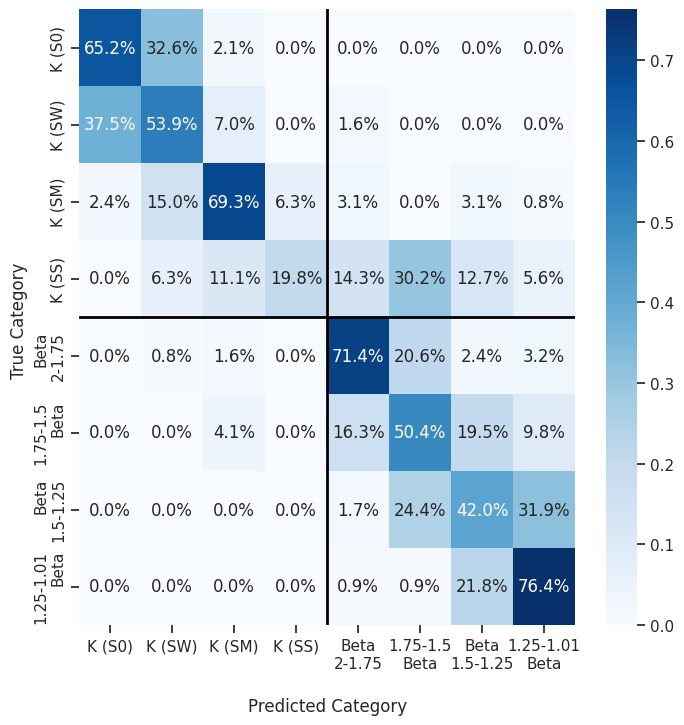

In [40]:
fig, ax = plt.subplots(1,1, figsize=(8, 8), sharex=True, sharey=False)

percentages = cf_matrix_exact/np.repeat(np.sum(cf_matrix_exact, 1), 8).reshape(8,8)
ax = sns.heatmap(percentages, annot=True, fmt='.1%', cmap='Blues')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('True Category ')
ax.xaxis.set_ticklabels(labels = renamed_labels)
ax.yaxis.set_ticklabels(labels = renamed_labels)
ax.axhline(y=4, color='black', linewidth=2)
ax.axvline(x=4, color='black', linewidth=2)
plt.show()

In [84]:
directory = "./classification-dataset-inf/"
files = os.listdir(directory)
files = [directory +  file for file in files]
print(len(files))

train_files = files[:int(len(files)*0.8)]
test_files = files[int(len(files)*0.8):]

5000


In [85]:
length = 60
loss_all = []
y_hats = []
y_trues = []
j = 0
with torch.no_grad():
    for i in tqdm(range(len(test_files))):
        data_objects = convert_for_classification(test_files[i])
        dl = DataLoader(data_objects, batch_size=len(data_objects))
        for batch in dl:
            batch = batch.to(device)
            y_hat = model(batch)
            y_hat = y_hat.sum(0) 
            y_true = batch.y[0]
            loss = criterion(y_hat, y_true) 
            loss = loss / accum_iter 
            
            loss_all.append(loss.item())            
            y_trues.append(y_true.item())
            y_hats.append(torch.argmax(y_hat).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
cf_matrix_exact_on_inferred = confusion_matrix(y_trues, y_hats)

In [62]:
model.load_state_dict(torch.load("./chkps/inferred_model_chkp19_3999.pth"))

<All keys matched successfully>

In [65]:
length = 60
loss_all = []
y_hats = []
y_trues = []
j = 0
with torch.no_grad():
    for i in tqdm(range(len(test_files))):
        data_objects = convert_for_classification(test_files[i])
        dl = DataLoader(data_objects, batch_size=len(data_objects))
        for batch in dl:
            batch = batch.to(device)
            y_hat = model(batch)
            y_hat = y_hat.sum(0) 
            y_true = batch.y[0]
            loss = criterion(y_hat, y_true) 
            loss = loss / accum_iter 
            
            loss_all.append(loss.item())            
            y_trues.append(y_true.item())
            y_hats.append(torch.argmax(y_hat).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [67]:
loss

tensor(0.0387, device='cuda:1')

In [66]:
cf_matrix_inferred_on_inferred = confusion_matrix(y_trues, y_hats)

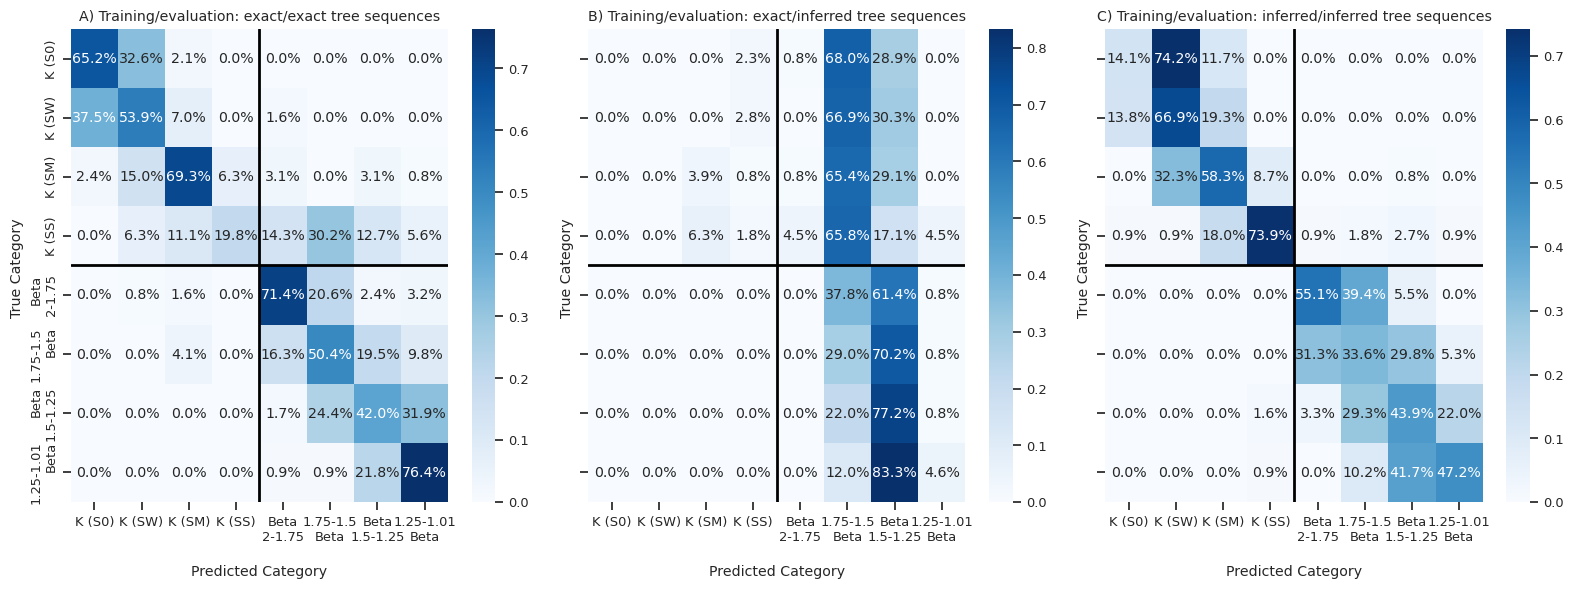

In [93]:
sns.set(font_scale=.85)
sns.set_style("ticks")


fig, axs = plt.subplots(1,3, figsize=(16, 6), sharex=True, sharey=True)

ax = axs[0]
percentages = cf_matrix_exact/np.repeat(np.sum(cf_matrix_exact, 1), 8).reshape(8,8)
ax = sns.heatmap(percentages, annot=True, fmt='.1%', cmap='Blues', ax=ax)
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('True Category ')
ax.xaxis.set_ticklabels(labels = renamed_labels)
ax.yaxis.set_ticklabels(labels = renamed_labels)
ax.axhline(y=4, color='black', linewidth=2)
ax.axvline(x=4, color='black', linewidth=2)
ax.set_title("A) Training/evaluation: exact/exact tree sequences")


ax = axs[1]
percentages = cf_matrix_exact_on_inferred/np.repeat(np.sum(cf_matrix_exact_on_inferred, 1), 8).reshape(8,8)
ax = sns.heatmap(percentages, annot=True, fmt='.1%', cmap='Blues', ax=ax)
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('True Category ')
ax.xaxis.set_ticklabels(labels = renamed_labels)
ax.yaxis.set_ticklabels(labels = renamed_labels)
ax.axhline(y=4, color='black', linewidth=2)
ax.axvline(x=4, color='black', linewidth=2)
ax.set_title("B) Training/evaluation: exact/inferred tree sequences")


ax = axs[2]
percentages = cf_matrix_inferred_on_inferred/np.repeat(np.sum(cf_matrix_inferred_on_inferred, 1), 8).reshape(8,8)
ax = sns.heatmap(percentages, annot=True, fmt='.1%', cmap='Blues', ax=ax)
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('True Category ')
ax.xaxis.set_ticklabels(labels = renamed_labels)
ax.yaxis.set_ticklabels(labels = renamed_labels)
ax.axhline(y=4, color='black', linewidth=2)
ax.axvline(x=4, color='black', linewidth=2)
ax.set_title("C) Training/evaluation: inferred/inferred tree sequences")

plt.tight_layout()

plt.savefig("confusion_exact_inferred.pdf", dpi=600)